# HRL (with Validation)

In [ ]:
import os
import time
import numpy as np
import pandas as pd
import torch
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef
from torch.utils.data import TensorDataset, DataLoader
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate_model(model_name, pretrained_model_path, tokenizer_class, model_class, train_data, val_data, batch_size, save_path, max_length=128, accumulation_steps=4, early_stopping_patience=3):
    # Load tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)
    
    # Function to tokenize data
    def tokenize_data(texts):
        return tokenizer(texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt")

    # Tokenize the train and validation data
    train_encodings = tokenize_data(train_data['comment'].tolist())
    val_encodings = tokenize_data(val_data['comment'].tolist())

    # Create labels tensors
    train_labels = torch.tensor(train_data['isToxic'].values)
    val_labels = torch.tensor(val_data['isToxic'].values)

    # Create TensorDatasets for train and validation sets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # Load model
    model = model_class.from_pretrained(pretrained_model_path, num_labels=1)
    model.to(device)

    # Initialize optimizer, loss
    learning_rate = 1e-5
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)  # Added weight decay
    criterion = torch.nn.BCEWithLogitsLoss()

    # Training parameters
    num_epochs = 50
    total_batches = len(train_dataloader)
    print_every = max(1, total_batches // 10)
    best_val_loss = float('inf')
    best_epoch = 0
    early_stopping_counter = 0

    # Training loop
    model.train()
    epoch_times = []

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []
    train_mccs = []
    val_mccs = []

    # Scheduler: Linear warmup and decay
    num_training_steps = num_epochs * len(train_dataloader) // accumulation_steps
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    # Create directory to save the best model
    model_save_dir = '../../temp/'
    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, 'best_model.pth')
    custom_save_dir = save_path

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        optimizer.zero_grad()

        for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            
            target = target.unsqueeze(1).float()
            
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = criterion(outputs.logits, target)
            loss = loss / accumulation_steps  # Normalize loss to account for gradient accumulation
            loss.backward()

            if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == total_batches:
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps  # Scale back the loss after accumulation

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            all_predictions.extend(preds)
            all_targets.extend(target.detach().cpu().numpy())

            if batch_idx % print_every == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item() * accumulation_steps:.4f}")

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        epoch_loss = running_loss / total_batches
        epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
        epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
        epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
        epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
        epoch_mcc = matthews_corrcoef(np.vstack(all_predictions), np.vstack(all_targets))

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_f1_scores.append(epoch_f1)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)
        train_mccs.append(epoch_mcc)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for input_ids, attention_mask, target in val_dataloader:
                input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

                target = target.unsqueeze(1).float()

                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
                preds = (preds > 0.5).astype(int)
                val_predictions.extend(preds)
                val_targets.extend(target.detach().cpu().numpy())

        val_loss /= len(val_dataloader)
        val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
        val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
        val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
        val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
        val_mcc = matthews_corrcoef(np.vstack(val_predictions), np.vstack(val_targets))

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_mccs.append(val_mcc)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
            # Save the best model to the temporary path
            torch.save(model.state_dict(), best_model_path)
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

        # Switch back to training mode
        model.train()

        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        estimated_total_time = avg_epoch_time * num_epochs
        remaining_time = estimated_total_time - sum(epoch_times)

        print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, MCC: {epoch_mcc:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}, Validation MCC: {val_mcc:.4f}")
        print(f"Estimated total training time: {estimated_total_time:.2f}s")
        print(f"Estimated remaining time: {remaining_time:.2f}s")

    print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
    print("Training completed.")

    # Save the best model to the custom path
    model.load_state_dict(torch.load(best_model_path))

    # Save the trained model
    model.save_pretrained(custom_save_dir)

    # Save metrics to a CSV file
    metrics_dict = {
        'Epoch': list(range(1, best_epoch + 2)),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Train F1 Score': train_f1_scores,
        'Train Precision': train_precisions,
        'Train Recall': train_recalls,
        'Train MCC': train_mccs,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies,
        'Val F1 Score': val_f1_scores,
        'Val Precision': val_precisions,
        'Val Recall': val_recalls,
        'Val MCC': val_mccs
    }

    metrics_filename = os.path.join(custom_save_dir, 'metrics.csv')
    with open(metrics_filename, 'w', newline='') as csvfile, open(metrics_filename.replace('.csv', '_detailed.csv'), 'w', newline='') as detailed_csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
        detailed_writer = csv.DictWriter(detailed_csvfile, fieldnames=['Epoch', 'Batch', 'Train Loss', 'Train Accuracy', 'Train F1 Score', 'Train Precision', 'Train Recall', 'Train MCC', 'Val Loss', 'Val Accuracy', 'Val F1 Score', 'Val Precision', 'Val Recall', 'Val MCC'])
        
        writer.writeheader()
        detailed_writer.writeheader()

        for row_idx in range(len(train_losses)):
            writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

        for epoch in range(best_epoch + 1):  # Iterate only up to the best_epoch
            for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
                batch_dict = {
                    'Epoch': epoch + 1,
                    'Batch': batch_idx + 1,
                    'Train Loss': train_losses[epoch],
                    'Train Accuracy': train_accuracies[epoch],
                    'Train F1 Score': train_f1_scores[epoch],
                    'Train Precision': train_precisions[epoch],
                    'Train Recall': train_recalls[epoch],
                    'Train MCC': train_mccs[epoch],
                    'Val Loss': val_losses[epoch],
                    'Val Accuracy': val_accuracies[epoch],
                    'Val F1 Score': val_f1_scores[epoch],
                    'Val Precision': val_precisions[epoch],
                    'Val Recall': val_recalls[epoch],
                    'Val MCC': val_mccs[epoch]
                }
                detailed_writer.writerow(batch_dict)

    # Plotting training and validation loss
    plt.figure(figsize=(12, 8))

    # Plot training loss
    plt.plot(train_losses, label='Training Loss', color='blue', linewidth=2, marker='o', markersize=5)
    # Plot validation loss
    plt.plot(val_losses, label='Validation Loss', color='orange', linewidth=2, marker='s', markersize=5)

    # Highlight the best epoch
    best_epoch_idx = best_epoch + 1
    plt.axvline(best_epoch_idx, linestyle='--', color='green', label='Best Epoch', linewidth=1.5)
    plt.annotate(f'Best Epoch: {best_epoch_idx}', xy=(best_epoch_idx, best_val_loss), xytext=(best_epoch_idx + 2, best_val_loss + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.05), fontsize=12, color='green')

    # Adding titles and labels
    plt.title('Training and Validation Loss per Epoch', fontsize=20)
    plt.xlabel('Epoch', fontsize=16)
    plt.ylabel('Loss', fontsize=16)

    # Adding grid, legend, and tight layout
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=14)
    plt.tight_layout()

    # Save and show the plot
    graphs_save_path = os.path.join(custom_save_dir, 'training_graphs.png')
    plt.savefig(graphs_save_path)
    plt.show()

    print("Results and graphs saved.")


In [ ]:

train_data = pd.read_csv('../../Datasets/Dataset_English/train/train.csv')
val_data = pd.read_csv('../../Datasets/Dataset_English/val/val.csv')

In [ ]:
# Check for null values
print("Checking for null values...")
print(train_data.isnull().sum())

# Fill or drop null values (choose one based on your preference)
train_data['comment'].fillna('', inplace=True)  # Fill with empty string
# train_data.dropna(subset=['comment'], inplace=True)  # Or drop rows with null comments

# Ensure all comments are strings
train_data['comment'] = train_data['comment'].astype(str)

# Verify the data again
print(train_data.head())

Checking for null values...
comment      102
comment.1    102
isToxic        0
dtype: int64
                                             comment  \
0  outrageous block outrageous un wiki lauren cai...   
1  except never dare say something new neil harbo...   
2  thanks reply explanation clarified issue perfe...   
3                           attempted generalization   
4     seem vandalising moving reference stupid place   

                                           comment.1  isToxic  
0  outrageous block outrageous un wiki lauren cai...        0  
1  except never dare say something new neil harbo...        0  
2  thanks reply explanation clarified issue perfe...        0  
3                           attempted generalization        0  
4     seem vandalising moving reference stupid place        1  


# English training mBERTu

In [10]:
# Usage example with reduced max_length and effective batch size via gradient accumulation
train_and_evaluate_model(
    model_name="MLRS/mBERTu",
    pretrained_model_path="MLRS/mBERTu",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,  # Effective batch size will be larger with gradient accumulation
    save_path="../../models/Experiments/Validation/Experiment-3/mBERTu_ENG",
    max_length=128,  # Reduced sequence length
    accumulation_steps= 4,  # Gradient accumulation steps
    early_stopping_patience=4  # Early stopping patience
)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at MLRS/mBERTu and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/8976: Loss: 0.7118
Epoch 1, Batch 898/8976: Loss: 0.0638
Epoch 1, Batch 1795/8976: Loss: 0.0960
Epoch 1, Batch 2692/8976: Loss: 0.2011
Epoch 1, Batch 3589/8976: Loss: 0.0385


KeyboardInterrupt: 

# English training BERT

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/8976: Loss: 0.7300
Epoch 1, Batch 898/8976: Loss: 0.0772
Epoch 1, Batch 1795/8976: Loss: 0.0162
Epoch 1, Batch 2692/8976: Loss: 0.0573
Epoch 1, Batch 3589/8976: Loss: 0.0424
Epoch 1, Batch 4486/8976: Loss: 0.0038
Epoch 1, Batch 5383/8976: Loss: 0.0398
Epoch 1, Batch 6280/8976: Loss: 0.1478
Epoch 1, Batch 7177/8976: Loss: 0.1339
Epoch 1, Batch 8074/8976: Loss: 0.0515
Epoch 1, Batch 8971/8976: Loss: 0.0340
Epoch 1 completed in 758.24s: Loss: 0.1066, Accuracy: 0.9605, F1 Score: 0.9619, Precision: 0.9644, Recall: 0.9605
Validation Loss: 0.0827, Validation Accuracy: 0.9692, Validation F1 Score: 0.9705, Validation Precision: 0.9734, Validation Recall: 0.9692
Estimated total training time: 45494.55s
Estimated remaining time: 44736.30s
Epoch 2, Batch 1/8976: Loss: 0.0714
Epoch 2, Batch 898/8976: Loss: 0.0646
Epoch 2, Batch 1795/8976: Loss: 0.0232
Epoch 2, Batch 2692/8976: Loss: 0.0527
Epoch 2, Batch 3589/8976: Loss: 0.0427
Epoch 2, Batch 4486/8976: Loss: 0.2159
Epoch 2, Batch 

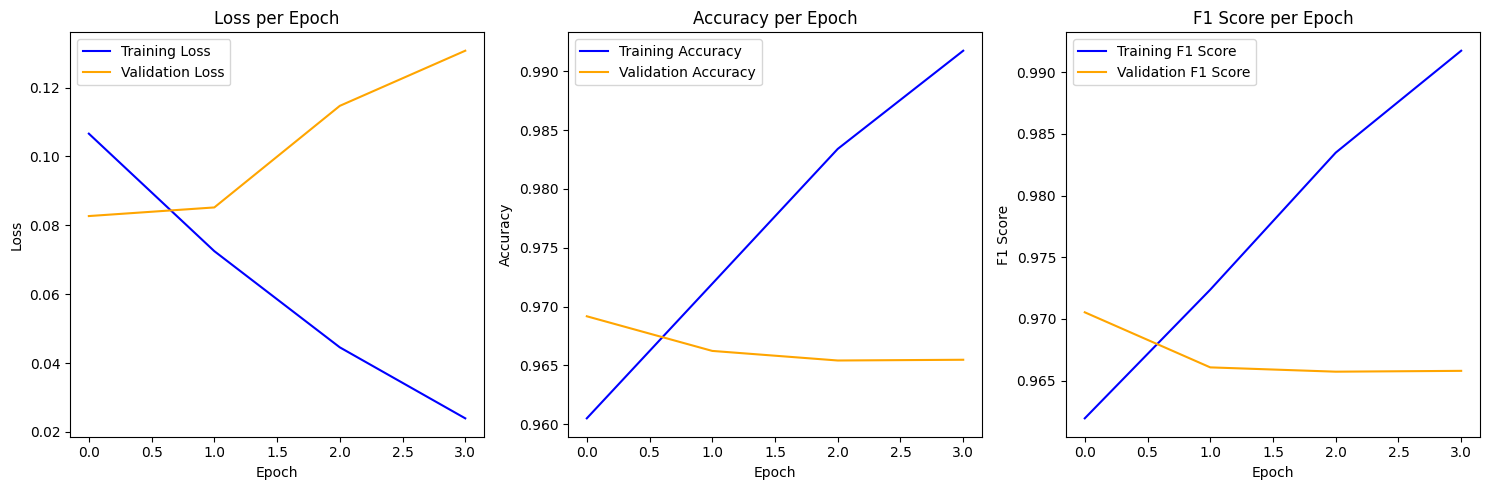

Results and graphs saved.


In [ ]:
# Usage example with reduced max_length and effective batch size via gradient accumulation
train_and_evaluate_model(
    model_name="bert-base-uncased",
    pretrained_model_path="bert-base-uncased",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,  # Effective batch size will be larger with gradient accumulation
    save_path="../../models/Experiments/Validation/Experiment-3/BERT_ENG",
    max_length=128,  # Reduced sequence length
    accumulation_steps=4,  # Gradient accumulation steps
    early_stopping_patience=5 # Early stopping patience
)

# English training XLM-R

In [ ]:
# Usage example with reduced max_length and effective batch size via gradient accumulation
train_and_evaluate_model(
    model_name='xlm-roberta-base',
    pretrained_model_path='xlm-roberta-base',
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,  # Effective batch size will be larger with gradient accumulation
    save_path="../../models/Experiments/Validation/Experiment-3/XLM-R_ENG",
    max_length=128,  # Reduced sequence length
    accumulation_steps=4,  # Gradient accumulation steps
    early_stopping_patience=5  # Early stopping patience
)

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(

Epoch 1, Batch 1/8976: Loss: 0.7720


KeyboardInterrupt: 

# English training RoBERTa

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Family-PC\.cache\huggingface\hub\models--roberta-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python a

Epoch 1, Batch 1/7979: Loss: 0.6093
Epoch 1, Batch 798/7979: Loss: 0.1872
Epoch 1, Batch 1595/7979: Loss: 0.0127
Epoch 1, Batch 2392/7979: Loss: 0.0527
Epoch 1, Batch 3189/7979: Loss: 0.0693
Epoch 1, Batch 3986/7979: Loss: 0.0286
Epoch 1, Batch 4783/7979: Loss: 0.0680
Epoch 1, Batch 5580/7979: Loss: 0.0116
Epoch 1, Batch 6377/7979: Loss: 0.0099
Epoch 1, Batch 7174/7979: Loss: 0.0040
Epoch 1, Batch 7971/7979: Loss: 0.0316
Epoch 1 completed in 660.71s: Loss: 0.1158, Accuracy: 0.9580, F1 Score: 0.9598, Precision: 0.9629, Recall: 0.9580
Validation Loss: 0.0924, Validation Accuracy: 0.9661, Validation F1 Score: 0.9666, Validation Precision: 0.9673, Validation Recall: 0.9661
Estimated total training time: 13214.24s
Estimated remaining time: 12553.53s
Epoch 2, Batch 1/7979: Loss: 0.0279
Epoch 2, Batch 798/7979: Loss: 0.0875
Epoch 2, Batch 1595/7979: Loss: 0.0212
Epoch 2, Batch 2392/7979: Loss: 0.0518
Epoch 2, Batch 3189/7979: Loss: 0.1208
Epoch 2, Batch 3986/7979: Loss: 0.0048
Epoch 2, Batch 

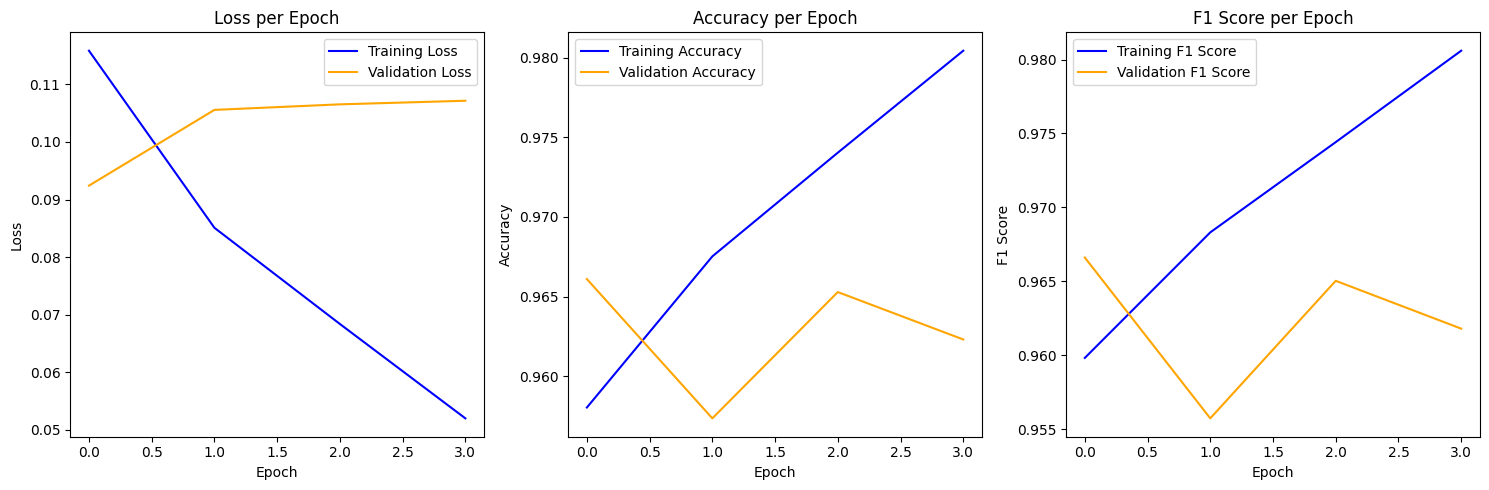

Results and graphs saved.


In [ ]:
# Usage example with reduced max_length and effective batch size via gradient accumulation
train_and_evaluate_model(
    model_name='roberta-base',
    pretrained_model_path='roberta-base',
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,  # Effective batch size will be larger with gradient accumulation
    save_path="../../models/Experiments/Validation/Experiment-3/RoBERTa_ENG",
    max_length=128,  # Reduced sequence length
    accumulation_steps=4,  # Gradient accumulation steps
    early_stopping_patience=5 # Early stopping patience
)

# Fine-Tuning (with Validation)

In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch
import csv
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torch.utils.data import TensorDataset, DataLoader
from torch.cuda.amp import autocast, GradScaler
from transformers import (
    AutoTokenizer,AutoModelForSequenceClassification,
    AdamW, get_linear_schedule_with_warmup
)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_and_evaluate_model(model_name, pretrained_model_path, tokenizer_class, model_class, train_data, val_data, batch_size, save_path):
    # Load tokenizer
    tokenizer = tokenizer_class.from_pretrained(model_name)
    
    # Function to tokenize data
    def tokenize_data(texts):
        return tokenizer(texts, padding="max_length", truncation=True, max_length=128, return_tensors="pt")

    # Tokenize the train and validation data
    train_encodings = tokenize_data(train_data['comment'].tolist())
    val_encodings = tokenize_data(val_data['comment'].tolist())

    # Create labels tensors
    train_labels = torch.tensor(train_data['isToxic'].values).float()
    val_labels = torch.tensor(val_data['isToxic'].values).float()

    # Create TensorDatasets for train and validation sets
    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], train_labels)
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], val_labels)

    # Create DataLoaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True)

    # Load model
    model = model_class.from_pretrained(pretrained_model_path, num_labels=1)
    model.to(device)

    # Initialize optimizer, loss, and scaler
    learning_rate = 2e-5
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = torch.nn.BCEWithLogitsLoss()
    scaler = torch.cuda.amp.GradScaler()

    # Early stopping parameters
    early_stopping_patience = 3
    best_val_loss = float('inf')
    best_epoch = 0
    early_stopping_counter = 0

    # Training parameters
    num_epochs = 50
    total_batches = len(train_dataloader)
    print_every = total_batches // 10

    # Training loop
    model.train()
    epoch_times = []

    # Lists to store metrics
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    train_precisions = []
    val_precisions = []
    train_recalls = []
    val_recalls = []

    # Scheduler: Linear warmup and decay
    num_training_steps = num_epochs * len(train_dataloader)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    # Create directory to save the best model
    model_save_dir = '../../temp/'
    os.makedirs(model_save_dir, exist_ok=True)
    best_model_path = os.path.join(model_save_dir, 'best_model.pth')
    custom_save_dir = save_path

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        running_loss = 0.0
        all_predictions = []
        all_targets = []

        for batch_idx, (input_ids, attention_mask, target) in enumerate(train_dataloader):
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)
            
            target = target.unsqueeze(1).float()
            optimizer.zero_grad()
            
            with autocast():
                outputs = model(input_ids, attention_mask=attention_mask)
                loss = criterion(outputs.logits, target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            running_loss += loss.item()

            preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
            preds = (preds > 0.5).astype(int)
            all_predictions.extend(preds)
            all_targets.extend(target.detach().cpu().numpy())

            if batch_idx % print_every == 0:
                print(f"Epoch {epoch+1}, Batch {batch_idx+1}/{total_batches}: Loss: {loss.item():.4f}")

        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        epoch_loss = running_loss / total_batches
        epoch_accuracy = accuracy_score(np.vstack(all_predictions), np.vstack(all_targets))
        epoch_f1 = f1_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
        epoch_precision = precision_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')
        epoch_recall = recall_score(np.vstack(all_predictions), np.vstack(all_targets), average='weighted')

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)
        train_f1_scores.append(epoch_f1)
        train_precisions.append(epoch_precision)
        train_recalls.append(epoch_recall)

        # Validation step
        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []

        with torch.no_grad():
            for input_ids, attention_mask, target in val_dataloader:
                input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

                target = target.unsqueeze(1).float()

                with autocast():
                    outputs = model(input_ids, attention_mask=attention_mask)
                    loss = criterion(outputs.logits, target)

                val_loss += loss.item()

                preds = torch.sigmoid(outputs.logits).detach().cpu().numpy()
                preds = (preds > 0.5).astype(int)
                val_predictions.extend(preds)
                val_targets.extend(target.detach().cpu().numpy())

        val_loss /= len(val_dataloader)
        val_accuracy = accuracy_score(np.vstack(val_predictions), np.vstack(val_targets))
        val_f1 = f1_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
        val_precision = precision_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')
        val_recall = recall_score(np.vstack(val_predictions), np.vstack(val_targets), average='weighted')

        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_epoch = epoch
            early_stopping_counter = 0
            # Save the best model to the temporary path
            torch.save(model.state_dict(), best_model_path)
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

        # Switch back to training mode
        model.train()

        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        estimated_total_time = avg_epoch_time * num_epochs
        remaining_time = estimated_total_time - sum(epoch_times)

        print(f"Epoch {epoch+1} completed in {epoch_time:.2f}s: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}, F1 Score: {epoch_f1:.4f}, Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}")
        print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}, Validation Precision: {val_precision:.4f}, Validation Recall: {val_recall:.4f}")
        print(f"Estimated total training time: {estimated_total_time:.2f}s")
        print(f"Estimated remaining time: {remaining_time:.2f}s")

    print(f"Best epoch: {best_epoch + 1}, Best validation loss: {best_val_loss:.4f}")
    print("Training completed.")

    # Save the best model to the custom path
    model.load_state_dict(torch.load(best_model_path))
    
    # Save the trained model
    model.save_pretrained(custom_save_dir)

    # Save metrics to a CSV file
    metrics_dict = {
        'Epoch': list(range(1, epoch + 2)),
        'Train Loss': train_losses,
        'Train Accuracy': train_accuracies,
        'Train F1 Score': train_f1_scores,
        'Train Precision': train_precisions,
        'Train Recall': train_recalls,
        'Val Loss': val_losses,
        'Val Accuracy': val_accuracies,
        'Val F1 Score': val_f1_scores,
        'Val Precision': val_precisions,
        'Val Recall': val_recalls
    }

    metrics_filename = os.path.join(custom_save_dir, 'metrics.csv')
    with open(metrics_filename, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=metrics_dict.keys())
        writer.writeheader()
        for row_idx in range(len(train_losses)):
            writer.writerow({key: metrics_dict[key][row_idx] for key in metrics_dict.keys()})

    # Plotting training and validation metrics
    plt.figure(figsize=(15, 5))

    # Plotting training and validation loss
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting training and validation accuracy
    plt.subplot(1, 3, 2)
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation F1 score
    plt.subplot(1, 3, 3)
    plt.plot(train_f1_scores, label='Training F1 Score', color='blue')
    plt.plot(val_f1_scores, label='Validation F1 Score', color='orange')
    plt.title('F1 Score per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()

    plt.tight_layout()

    # Save and show the plot
    graphs_save_path = os.path.join(custom_save_dir, 'training_graphs.png')
    plt.savefig(graphs_save_path)
    plt.show()

    print("Results and graphs saved.")


c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

train_data = pd.read_csv('../../Datasets/Dataset_Maltese/train/validation/train.csv')
val_data = pd.read_csv('../../Datasets/Dataset_Maltese/train/validation/val.csv')

In [3]:
# Check for null values in the dataset
print("Checking for null values in the dataset...")
print("Train Data Null Values:\n", train_data.isnull().sum())
print("Validation Data Null Values:\n", val_data.isnull().sum())

# Handle null values in the 'comment' and 'isToxic' columns
train_data['comment'].fillna('', inplace=True)
val_data['comment'].fillna('', inplace=True)
train_data['isToxic'].fillna(0, inplace=True)
val_data['isToxic'].fillna(0, inplace=True)

# Verify the data again
print("Verifying train data after handling NaNs:")
print(train_data.isnull().sum())
print(train_data.head())

print("Verifying validation data after handling NaNs:")
print(val_data.isnull().sum())
print(val_data.head())

Checking for null values in the dataset...
Train Data Null Values:
 comment    0
isToxic    1
dtype: int64
Validation Data Null Values:
 comment    0
isToxic    0
dtype: int64
Verifying train data after handling NaNs:
comment    0
isToxic    0
dtype: int64
                                             comment  isToxic
0  prosit tassew int verament għamilt xogħol mill...      0.0
1  s sibt normal episode kitbet yasmine u ghada s...      0.0
2  prosit tassew għandek talent kbir u qed tagħme...      0.0
3                            ghandha karattru din ta      0.0
4  majal mux animal miskin hu koll ghala toqtluh ...      1.0
Verifying validation data after handling NaNs:
comment    0
isToxic    0
dtype: int64
                                             comment  isToxic
0  propjament lissponsor ta nuccalijiet dizastru ...        0
1  ma nistax nemmen kemm int stupidu tmur lura li...        1
2  sharon smajtha din trid xi hadd isabbatha qale...        1
3                verament tqazzek xit

# Fine-Tuning mBERTu

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/243: Loss: 0.8205
Epoch 1, Batch 25/243: Loss: 0.4025
Epoch 1, Batch 49/243: Loss: 0.2551
Epoch 1, Batch 73/243: Loss: 0.2535
Epoch 1, Batch 97/243: Loss: 0.5003
Epoch 1, Batch 121/243: Loss: 0.3887
Epoch 1, Batch 145/243: Loss: 0.1635
Epoch 1, Batch 169/243: Loss: 0.3070
Epoch 1, Batch 193/243: Loss: 0.3519
Epoch 1, Batch 217/243: Loss: 0.1597
Epoch 1, Batch 241/243: Loss: 0.3193
Epoch 1 completed in 36.19s: Loss: 0.3643, Accuracy: 0.8200, F1 Score: 0.8217, Precision: 0.8257, Recall: 0.8200
Validation Loss: 0.3096, Validation Accuracy: 0.8345, Validation F1 Score: 0.8379, Validation Precision: 0.8506, Validation Recall: 0.8345
Estimated total training time: 1809.72s
Estimated remaining time: 1773.53s
Epoch 2, Batch 1/243: Loss: 0.3299
Epoch 2, Batch 25/243: Loss: 0.1385
Epoch 2, Batch 49/243: Loss: 0.2272
Epoch 2, Batch 73/243: Loss: 0.1767
Epoch 2, Batch 97/243: Loss: 0.2329
Epoch 2, Batch 121/243: Loss: 0.1457
Epoch 2, Batch 145/243: Loss: 0.2570
Epoch 2, Batch 169/

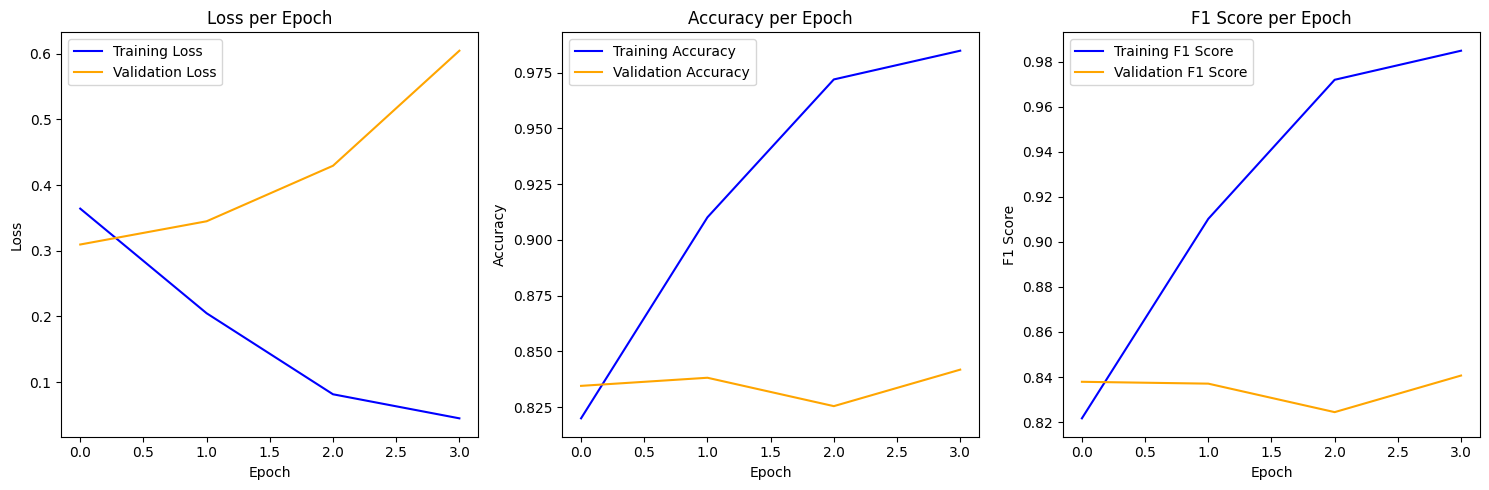

Results and graphs saved.


In [4]:
# Training mBERTu
train_and_evaluate_model(
    model_name="MLRS/mBERTu",
    pretrained_model_path="../../models/Experiments/Validation/Experiment-1/mBERTu_ENG",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,
    save_path="../../models/Experiments/Validation/Experiment-2/mBERTu_FT"
)

# Fine-Tuning BERT

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/243: Loss: 0.6808
Epoch 1, Batch 25/243: Loss: 0.6804
Epoch 1, Batch 49/243: Loss: 0.2854
Epoch 1, Batch 73/243: Loss: 0.4583
Epoch 1, Batch 97/243: Loss: 0.3015
Epoch 1, Batch 121/243: Loss: 0.6040
Epoch 1, Batch 145/243: Loss: 0.2573
Epoch 1, Batch 169/243: Loss: 0.2963
Epoch 1, Batch 193/243: Loss: 0.2462
Epoch 1, Batch 217/243: Loss: 0.3977
Epoch 1, Batch 241/243: Loss: 0.5238
Epoch 1 completed in 32.60s: Loss: 0.4440, Accuracy: 0.7685, F1 Score: 0.7788, Precision: 0.8125, Recall: 0.7685
Validation Loss: 0.3754, Validation Accuracy: 0.8273, Validation F1 Score: 0.8301, Validation Precision: 0.8397, Validation Recall: 0.8273
Estimated total training time: 1629.99s
Estimated remaining time: 1597.39s
Epoch 2, Batch 1/243: Loss: 0.3263
Epoch 2, Batch 25/243: Loss: 0.1959
Epoch 2, Batch 49/243: Loss: 0.3978
Epoch 2, Batch 73/243: Loss: 0.3200
Epoch 2, Batch 97/243: Loss: 0.4878
Epoch 2, Batch 121/243: Loss: 0.1858
Epoch 2, Batch 145/243: Loss: 0.2507
Epoch 2, Batch 169/

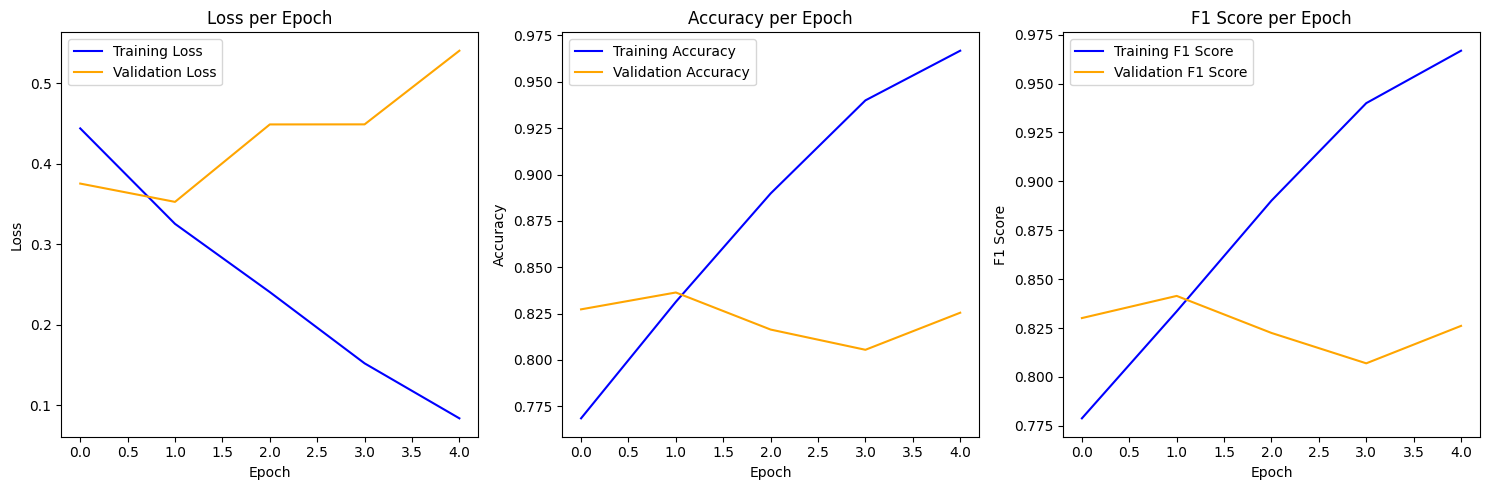

Results and graphs saved.


In [5]:
# Training BERT
train_and_evaluate_model(
    model_name="bert-base-uncased",
    pretrained_model_path="../../models/Experiments/Validation/Experiment-1/BERT_ENG",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,
    save_path="../../models/Experiments/Validation/Experiment-2/BERT_FT"
)

# Fine-Tuning XLM-R

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/243: Loss: 0.6854
Epoch 1, Batch 25/243: Loss: 0.4522
Epoch 1, Batch 49/243: Loss: 0.4052
Epoch 1, Batch 73/243: Loss: 0.3679
Epoch 1, Batch 97/243: Loss: 0.6917
Epoch 1, Batch 121/243: Loss: 0.3839
Epoch 1, Batch 145/243: Loss: 0.4832
Epoch 1, Batch 169/243: Loss: 0.3021
Epoch 1, Batch 193/243: Loss: 0.2548
Epoch 1, Batch 217/243: Loss: 0.4633
Epoch 1, Batch 241/243: Loss: 0.5438
Epoch 1 completed in 144.13s: Loss: 0.4501, Accuracy: 0.7793, F1 Score: 0.7890, Precision: 0.8222, Recall: 0.7793
Validation Loss: 0.3850, Validation Accuracy: 0.8164, Validation F1 Score: 0.8206, Validation Precision: 0.8357, Validation Recall: 0.8164
Estimated total training time: 7206.60s
Estimated remaining time: 7062.47s
Epoch 2, Batch 1/243: Loss: 0.3512
Epoch 2, Batch 25/243: Loss: 0.4656
Epoch 2, Batch 49/243: Loss: 0.4444
Epoch 2, Batch 73/243: Loss: 0.3555
Epoch 2, Batch 97/243: Loss: 0.5011
Epoch 2, Batch 121/243: Loss: 0.5537
Epoch 2, Batch 145/243: Loss: 0.2360
Epoch 2, Batch 169

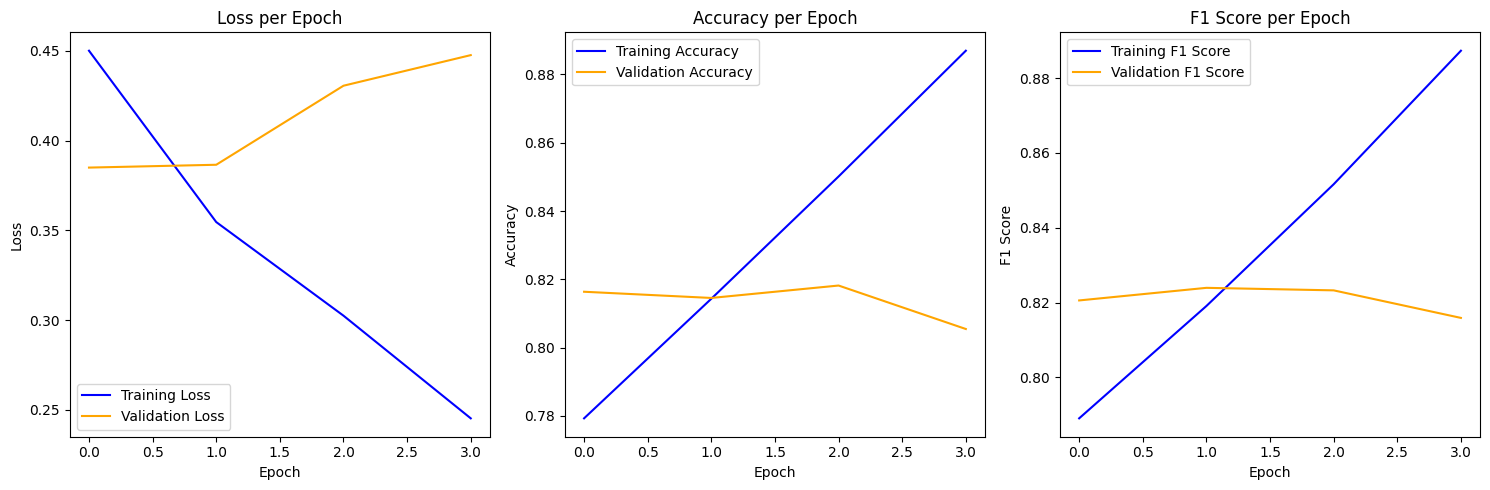

Results and graphs saved.


In [6]:
# Training XLM-R
train_and_evaluate_model(
    model_name="xlm-roberta-base",
    pretrained_model_path="../../models/Experiments/Validation/Experiment-1/XLM-R_ENG",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,
    save_path="../../models/Experiments/Validation/Experiment-2/XLM-R_FT"
)

# Fine-Tuning RoBERTa

c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\Family-PC\miniconda3\envs\thesis\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1, Batch 1/243: Loss: 0.6891
Epoch 1, Batch 25/243: Loss: 0.6921
Epoch 1, Batch 49/243: Loss: 0.5160
Epoch 1, Batch 73/243: Loss: 0.5895
Epoch 1, Batch 97/243: Loss: 0.3566
Epoch 1, Batch 121/243: Loss: 0.5066
Epoch 1, Batch 145/243: Loss: 0.7035
Epoch 1, Batch 169/243: Loss: 0.7154
Epoch 1, Batch 193/243: Loss: 0.9316
Epoch 1, Batch 217/243: Loss: 0.2473
Epoch 1, Batch 241/243: Loss: 0.3365
Epoch 1 completed in 38.47s: Loss: 0.4654, Accuracy: 0.7610, F1 Score: 0.7738, Precision: 0.8160, Recall: 0.7610
Validation Loss: 0.4100, Validation Accuracy: 0.8036, Validation F1 Score: 0.8075, Validation Precision: 0.8198, Validation Recall: 0.8036
Estimated total training time: 1923.73s
Estimated remaining time: 1885.26s
Epoch 2, Batch 1/243: Loss: 0.4253
Epoch 2, Batch 25/243: Loss: 0.4002
Epoch 2, Batch 49/243: Loss: 0.2592
Epoch 2, Batch 73/243: Loss: 0.1516
Epoch 2, Batch 97/243: Loss: 0.4784
Epoch 2, Batch 121/243: Loss: 0.2538
Epoch 2, Batch 145/243: Loss: 0.2426
Epoch 2, Batch 169/

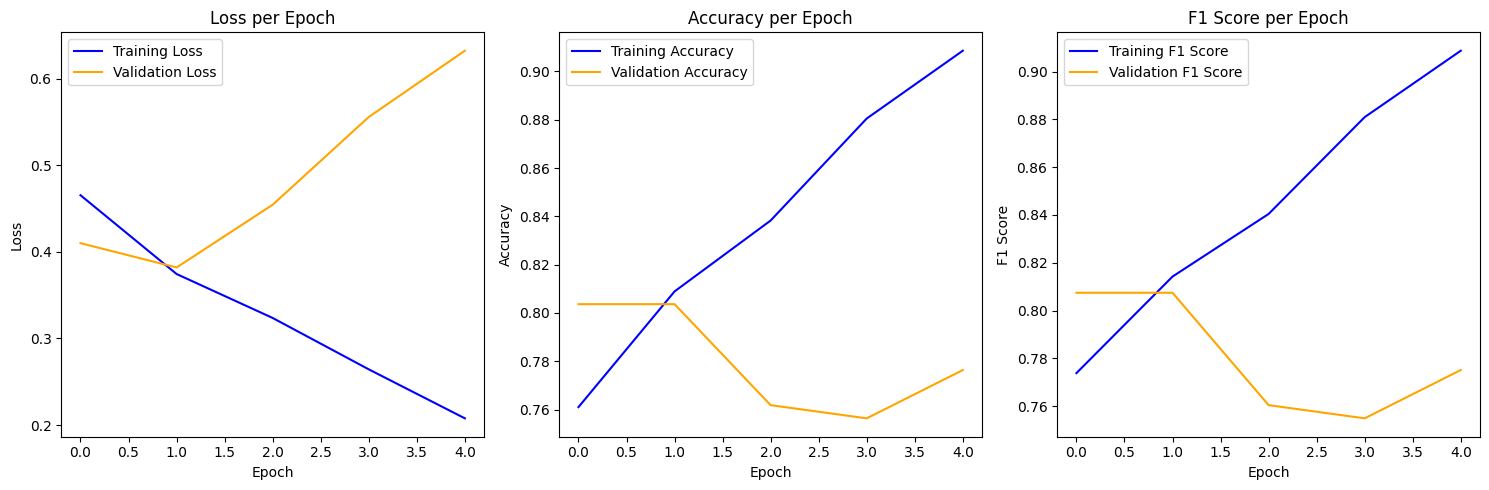

Results and graphs saved.


In [7]:
# Training RoBERTa
train_and_evaluate_model(
    model_name="roberta-base",
    pretrained_model_path="../../models/Experiments/Validation/Experiment-1/RoBERTa_ENG",
    tokenizer_class=AutoTokenizer,
    model_class=AutoModelForSequenceClassification,
    train_data=train_data,
    val_data=val_data,
    batch_size=16,
    save_path="../../models/Experiments/Validation/Experiment-2/RoBERTa_FT"
)